In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import struct
import gzip
import os
from algs import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from models.dbsl import DBSL
from algs import  LinUCB, LinUCBwithPSI_Batch
import numpy as np
from collections import defaultdict
from numpy.linalg import multi_dot
from scipy.linalg import svd, qr, norm
from math import sqrt
from env_mnist import *

In [5]:
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([(clusters[k].shape) for k in range(10)])

(60000, 784)
[(5923, 784), (6742, 784), (5958, 784), (6131, 784), (5842, 784), (5421, 784), (5918, 784), (6265, 784), (5851, 784), (5949, 784)]


In [3]:
#cbscfd

In [8]:
def run_experiment_cbscfd(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)
    
    env = MNISTBanditEnv(clusters, target_class=9)
    bandit = CBSCFD(num_arms=10, lambd=lambd, beta=beta, m=m, d=784)
    
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)
    
    return env.cumulative_mistakes

In [9]:
T = 4000
n_runs = 5
m = 10
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes = run_experiment_cbscfd(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


  0%|          | 0/4000 [00:00<?, ?it/s]


TypeError: CBSCFD.score() takes 2 positional arguments but 3 were given

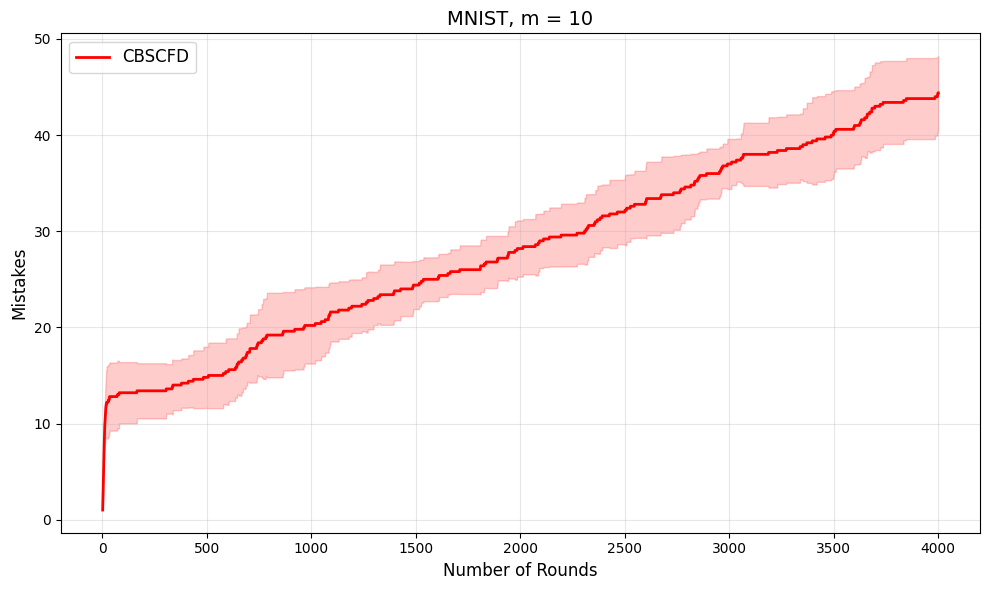

In [21]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='CBSCFD', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#psi_rank1

In [16]:
def run_experiment_psi(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)

    env = MNISTBanditEnv(clusters, target_class=9)
    bandit = LinUCBwithPSI_rank1(num_arms=10,d=784, epsilon=lambd, alpha=beta, rank=m)
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)

    return env.cumulative_mistakes

In [17]:
T = 4000
n_runs = 5
m = 64
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes = run_experiment_psi(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


100%|██████████| 4000/4000 [00:42<00:00, 93.05it/s] 



Run 2/5


100%|██████████| 4000/4000 [00:40<00:00, 98.75it/s] 



Run 3/5


100%|██████████| 4000/4000 [00:40<00:00, 99.13it/s] 



Run 4/5


100%|██████████| 4000/4000 [00:38<00:00, 104.66it/s]



Run 5/5


100%|██████████| 4000/4000 [00:30<00:00, 133.23it/s]


num mistakes 25.2


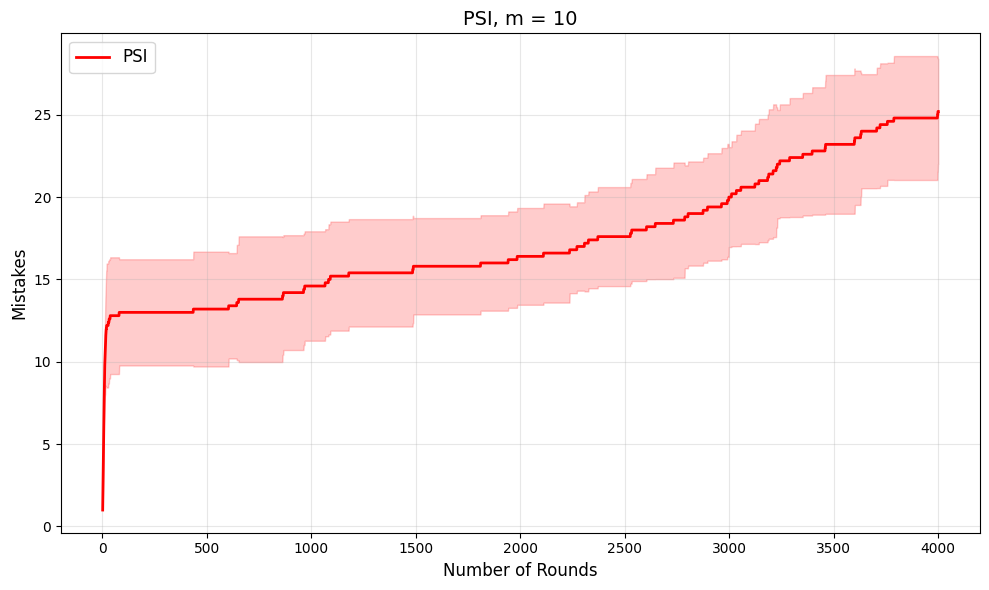

In [18]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='PSI', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('PSI, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

100%|██████████| 4000/4000 [05:26<00:00, 12.24it/s]


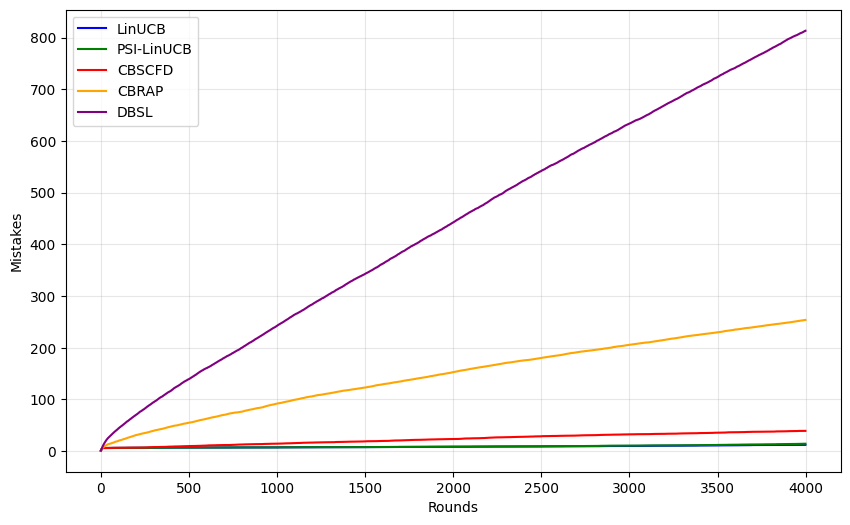


Final Results:
LinUCB: 12.2 ± 2.9
PSI-LinUCB: 14.3 ± 3.2
CBSCFD: 39.2 ± 2.7
CBRAP: 253.8 ± 99.3
DBSL: 813.4 ± 25.9


In [27]:
T = 4000
n_runs = 20
d = 784
num_arms = 10
lambd = epsilon = 1
beta = alpha = 1
m = 10 #из статьи

m_cbrap = 10

sketch =50 #из статьи
eps = 8 #из статьи

rank =96 #96



results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, alpha, epsilon)
    psi = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
    cbscfd = CBSCFD(num_arms, lambd, beta, m, d)
    cbrap = CBRAP(num_arms, d, lambd, beta, m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=8)
    env_psi = MNISTBanditEnv(clusters, target_class=8)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=8)
    env_cbrap = MNISTBanditEnv(clusters, target_class=8)
    env_dbsl = MNISTBanditEnv(clusters, target_class=8)

    for t in trange(T):
        contexts = env_linucb.get_contexts()

        #LinUCB
        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        #linucb.append_interaction(contexts[action], action, reward)
        #linucb.batch_update([action])
        linucb.update(contexts[action], action, reward)

        #PSI-LinUCB
        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        #CBSCFD
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        #CBRAP
        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

        #DBSL
        def observe(ind, x):
            return env_dbsl.step(ind)
        dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    results['DBSL'].append(env_dbsl.cumulative_mistakes)

plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', 'DBSL': 'purple'}
for name in results:
    mean = np.mean(results[name], axis=0)
    plt.plot(mean, label=name, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("\nFinal Results:")

for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

Running cross-validation...
LinUCB best: {'alpha': 0.0001, 'epsilon': 0.02}, mistakes: 1
PSI-LinUCB best: {'alpha': 2, 'epsilon': 20000}, mistakes: 1
CBSCFD best: {'beta': 0.1, 'lambd': 20}, mistakes: 1
CBRAP best: {'beta': 0.001, 'lambd': 0.02}, mistakes: 10
DBSL best: {'beta': 0.01, 'lambd': 0.2}, mistakes: 203
Run 1/20


Run 2/20


Run 3/20


Run 4/20


Run 5/20


Run 6/20


Run 7/20


Run 8/20


Run 9/20


Run 10/20


Run 11/20


Run 12/20


Run 13/20


Run 14/20


Run 15/20


Run 16/20


Run 17/20


Run 18/20


Run 19/20


Run 20/20


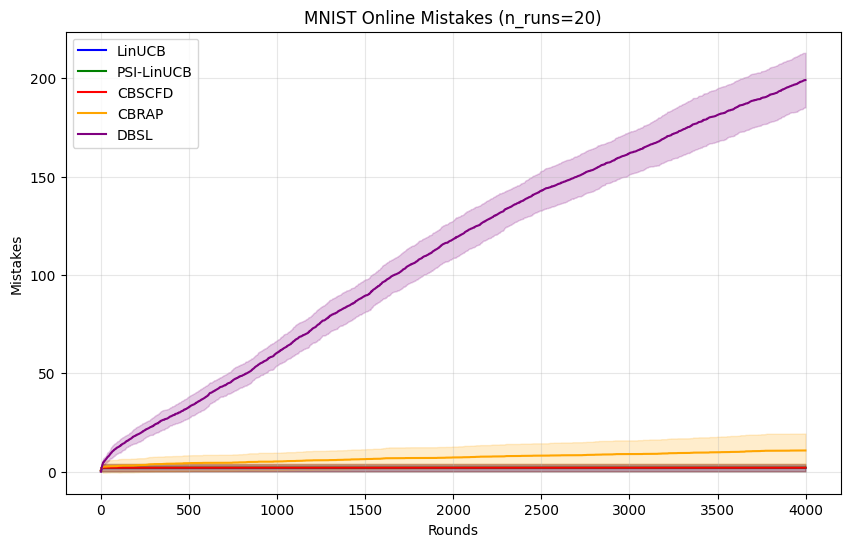


Final Results:
LinUCB: 1.9 ± 1.6
PSI-LinUCB: 2.0 ± 1.9
CBSCFD: 2.0 ± 1.9
CBRAP: 10.8 ± 8.6
DBSL: 199.1 ± 13.9


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

betas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]
#lambdas = [1]

T_cv = 4000
T = 4000
n_runs = 20
d = 784
num_arms = 10
m = 10
m_cbrap = 10
sketch = 50
rank = 100
eps = 8


def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(num_arms, d, alpha, epsilon)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBSCFD(num_arms, lambd, beta, m, d)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBRAP(num_arms, d, lambd, beta, m_cbrap)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_dbsl():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            def observe(ind, x): return env.step(ind)
            bandit.fit(ctx, observe)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"DBSL best: {best_params}, mistakes: {best_score}")
    return best_params


print("Running cross-validation...")
params_linucb = cv_linucb()
params_psi = cv_psi()
params_cbscfd = cv_cbscfd()
params_cbrap = cv_cbrap()
params_dbsl = cv_dbsl()


results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, params_linucb['alpha'], params_linucb['epsilon'])
    psi = LinUCBwithPSI_rank1(num_arms, d, params_psi['epsilon'], params_psi['alpha'], rank)
    cbscfd = CBSCFD(num_arms, params_cbscfd['lambd'], params_cbscfd['beta'], m, d)
    cbrap = CBRAP(num_arms, d, params_cbrap['lambd'], params_cbrap['beta'], m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=params_dbsl['beta'], lmd=params_dbsl['lambd'], robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=0)
    env_psi = MNISTBanditEnv(clusters, target_class=0)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=0)
    env_cbrap = MNISTBanditEnv(clusters, target_class=0)
    env_dbsl = MNISTBanditEnv(clusters, target_class=0)

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], action, reward)

        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

        def observe(ind, x): return env_dbsl.step(ind)
        dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    results['DBSL'].append(env_dbsl.cumulative_mistakes)


plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', 'DBSL': 'purple'}
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    plt.plot(mean, label=name, color=colors[name])
    plt.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'MNIST Online Mistakes (n_runs={n_runs})')
plt.show()


print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

In [20]:
from tqdm import trange
from algs_one_mtx import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from models.dbsl import DBSL

from env_mnist import *

In [13]:
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([(clusters[k].shape) for k in range(10)])

(60000, 784)
[(5923, 784), (6742, 784), (5958, 784), (6131, 784), (5842, 784), (5421, 784), (5918, 784), (6265, 784), (5851, 784), (5949, 784)]


(60000, 784)
[(5923, 784), (6742, 784), (5958, 784), (6131, 784), (5842, 784), (5421, 784), (5918, 784), (6265, 784), (5851, 784), (5949, 784)]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

betas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]

T_cv = 4000
T = 4000
n_runs = 1
d = 784
num_arms = 10
m = 10
m_cbrap = 10
sketch = 50
rank = 10
eps = 8


def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(d, alpha, epsilon)
        env = MNISTBanditEnv(clusters, target_class=8)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(d, epsilon, alpha, rank)
        env = MNISTBanditEnv(clusters, target_class=8)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBSCFD(lambd, beta, m, d)
        env = MNISTBanditEnv(clusters, target_class=8)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBRAP(d, lambd, beta, m_cbrap)
        env = MNISTBanditEnv(clusters, target_class=8)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_dbsl():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            def observe(ind, x): return env.step(ind)
            bandit.fit(ctx, observe)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"DBSL best: {best_params}, mistakes: {best_score}")
    return best_params


print("Running cross-validation...")
params_psi = cv_psi()
params_linucb = cv_linucb()

params_cbscfd = cv_cbscfd()
params_cbrap = cv_cbrap()
# params_dbsl = cv_dbsl()


results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, params_linucb['alpha'], params_linucb['epsilon'])
    psi = LinUCBwithPSI_rank1(d, params_psi['epsilon'], params_psi['alpha'], rank)
    cbscfd = CBSCFD(params_cbscfd['lambd'], params_cbscfd['beta'], m, d)
    cbrap = CBRAP(d, params_cbrap['lambd'], params_cbrap['beta'], m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=params_dbsl['beta'], lmd=params_dbsl['lambd'], robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=8)
    env_psi = MNISTBanditEnv(clusters, target_class=8)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=8)
    env_cbrap = MNISTBanditEnv(clusters, target_class=8)
    # env_dbsl = MNISTBanditEnv(clusters, target_class=0)

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)

        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)



        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)

        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)

        # def observe(ind, x): return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)


plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange' , 'DBSL':'purple'}
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    plt.plot(mean, label=name, color=colors[name])
    plt.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'MNIST Online Mistakes (n_runs={n_runs})')
plt.show()


print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

Running cross-validation...
PSI-LinUCB best: {'alpha': 0.1, 'epsilon': 2}, mistakes: 982


KeyboardInterrupt: 

In [ ]:
1. Ранги 10 - target 0
LinUCB best: {'alpha': 0.0001, 'epsilon': 0.2}, mistakes: 155
PSI-LinUCB best: {'alpha': 0.01, 'epsilon': 2}, mistakes: 291
CBSCFD best: {'beta': 0.001, 'lambd': 0.2}, mistakes: 373
CBRAP best: {'beta': 0.01, 'lambd': 0.0002}, mistakes: 1421

2. оптимал - target 8
LinUCB: {'alpha': 0.0001, 'epsilon': 0.2}
PSI-LinUCB: {'alpha': 0.01, 'epsilon': 2, 'rank': 90}
CBSCFD: {'beta': 0.001, 'lambd': 0.2, 'm': 90}
#CBSCFD: {'beta': 0.0001, 'lambd': 0.02, 'm': 90}_1
CBRAP best: {'beta': 0.01, 'lambd': 0.2, 'm': 200}, mistakes: 176
DBSL best: {'beta': 0.001, 'lambd': 0.2}, mistakes: 183

3.
LinUCB: {'alpha': 0.0001, 'epsilon': 0.2}
PSI-LinUCB: {'alpha': 0.01, 'epsilon': 2, 'rank': 90}
CBSCFD: {'beta': 0.0001, 'lambd': 0.02, 'm': 100}
CBRAP: {'beta': 0.0001, 'lambd': 0.2, 'm': 90}



In [51]:
import numpy as np
from numpy.linalg import svd
from collections import defaultdict
from numpy.linalg import multi_dot
from scipy.linalg import qr, norm
from math import sqrt
def integrator(tilde_Ut, S, tilde_Vt, delta_U, delta_V):
    Ut = tilde_Ut.copy()
    Vt = tilde_Vt.copy()
    K1 = Ut @ S + delta_U.dot(delta_V.T.dot(Vt))
    tilde_U1, tilde_S1 = qr(K1, mode="economic")
    tilde_S0 = tilde_S1 - tilde_U1.T.dot(delta_U.dot(delta_V.T.dot(Vt)))
    L1 = Vt.dot(tilde_S0.T) + delta_V.dot(delta_U.T.dot(tilde_U1))
    tilde_V1, S1 = qr(L1, mode="economic")
    S1 = S1.T
    return tilde_U1, S1, tilde_V1


def svd_U_V_T(U, V, rank):
    Q_U, R_U = qr(U, mode="economic")
    Q_V, R_V = qr(V, mode="economic")

    U_svd, S_svd, V_svd = svd(R_U.dot(R_V.T), full_matrices=False)

    U_svd = U_svd[:, :rank]
    S_svd = S_svd[:rank]
    V_svd = V_svd[:rank, :]

    U_new = Q_U.dot(U_svd)
    V_new = V_svd.dot(Q_V.T)

    return U_new, np.diag(S_svd), V_new.T
class LinUCBwithPSI_rank1:
    def __init__(self, d=10, epsilon=1.0, alpha=1.0, rank=10):
        self.d = d
        self.epsilon = epsilon
        self.sqrt_epsilon = 1 / sqrt(epsilon)
        self.alpha = alpha
        self.rank = rank

        self.U = np.zeros((d, 2 * rank))
        self.V = np.zeros((d, 2 * rank))
        self.n_cols = 0

        self.Ut = None
        self.St = None
        self.Vt = None

        self.b = np.zeros(self.d, dtype=np.float32)
        self.theta = np.zeros(self.d, dtype=np.float32)

    def _L_matvec(self, vec):
        L_0_inv_vec = self.sqrt_epsilon * vec.copy()
        if self.n_cols == 0:
            return L_0_inv_vec
        U = self.U[:, :self.n_cols]
        V = self.V[:, :self.n_cols]
        return L_0_inv_vec - U @ (V.T @ L_0_inv_vec)

    def update(self, context, reward):
        self.b += reward * context

        bar_x = self._L_matvec(vec=context)

        norm_bar_x_sq = norm(bar_x) ** 2
        if norm_bar_x_sq < 1e-12:
            self._update_theta()
            return

        alpha_t = (sqrt(1 + norm_bar_x_sq) - 1) / norm_bar_x_sq
        beta_t = alpha_t / (1 + alpha_t * norm_bar_x_sq)

        self._update_factors(bar_x=bar_x, beta_t=beta_t)
        self._update_theta()

    def _update_factors(self, bar_x, beta_t):
        delta_u = beta_t * bar_x

        if self.n_cols > 0:
            U = self.U[:, :self.n_cols]
            V = self.V[:, :self.n_cols]
            delta_v = bar_x - V @ (U.T @ bar_x)
        else:
            delta_v = bar_x

        self.U[:, self.n_cols] = delta_u
        self.V[:, self.n_cols] = delta_v
        self.n_cols += 1

        if self.n_cols == 2 * self.rank:
            if self.Ut is None:
                self.Ut, self.St, self.Vt = svd_U_V_T(
                    self.U[:, :self.rank], self.V[:, :self.rank], self.rank
                )

            delta_U_new = self.U[:, self.rank:self.n_cols]
            delta_V_new = self.V[:, self.rank:self.n_cols]
            self.Ut, self.St, self.Vt = integrator(
                self.Ut, self.St, self.Vt, delta_U_new, delta_V_new
            )


            US = self.Ut @ self.St
            self.U[:, :self.rank] = US
            self.V[:, :self.rank] = self.Vt
            self.n_cols = self.rank  #сбрасываем

    def _update_theta(self):
        b_eps = self.epsilon * self.b
        if self.n_cols == 0:
            self.theta = b_eps
            return

        U = self.U[:, :self.n_cols]
        V = self.V[:, :self.n_cols]

        Ub = U.T @ b_eps
        Vb = V.T @ b_eps
        self.theta = b_eps - V @ Ub - U @ Vb + V @ (U.T @ (U @ Vb))

    def score1(self, context):
        ctx = context
        mean = float(np.dot(self.theta.T, ctx))

        if self.n_cols == 0:
            diff_sq = np.dot(ctx, ctx)
        else:
            U = self.U[:, :self.n_cols]
            V = self.V[:, :self.n_cols]
            v = V.T @ ctx
            Uv = U @ v
            diff_sq = np.dot(ctx, ctx) - 2 * np.dot(ctx, Uv) + np.dot(Uv, Uv)

        exp = self.sqrt_epsilon * np.sqrt(max(diff_sq, 0))
        return mean + self.alpha * exp

    def score(self, context):
        ctx = context
        mean = float(np.dot(self.theta.T, ctx))
        U = self.U[:, :self.n_cols]
        V = self.V[:, :self.n_cols]
        v = V.T @ ctx
        exp = self.sqrt_epsilon * np.linalg.norm(ctx - (U @ v))
        return mean + self.alpha * exp

    def select_arm(self, contexts):
        scores = [self.score(ctx) for ctx in contexts]
        return int(np.argmax(scores))

def getStartingValues(u, v, k):
    Qu, Ru = np.linalg.qr(u)
    Qv, Rv = np.linalg.qr(v)


    small_matrix = Ru @ Rv.T

    try:
        U_s, S, Vh_s = np.linalg.svd(small_matrix, full_matrices=False)
    except np.linalg.LinAlgError:

        print('reg')
        reg = 1e-10 * np.eye(small_matrix.shape[0])
        small_matrix_reg = small_matrix + reg
        U_s, S, Vh_s = np.linalg.svd(small_matrix_reg, full_matrices=False)

    U_s = U_s[:, :k]
    S = S[:k]
    S = np.diag(S)
    Vh_s = Vh_s[:k, :]

    U = Qu @ U_s
    V = Qv @ Vh_s.T
    #print(U.shape)
    #print( U, S, V)

    return U, S, V

Run 1/1


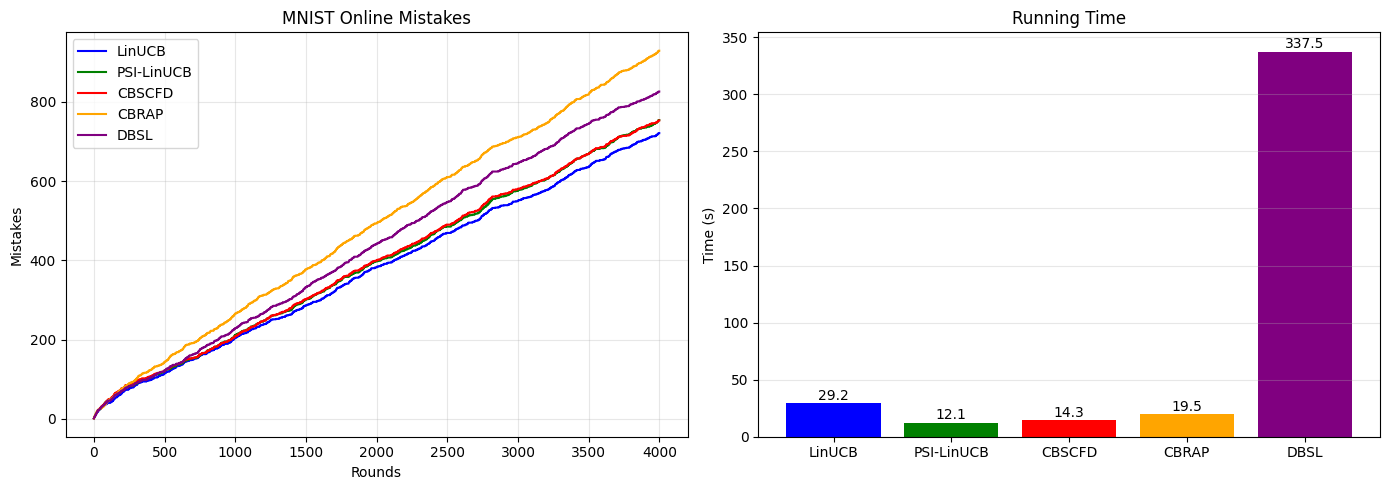


Final Results:
LinUCB: Mistakes=721.0, Time=29.2s
PSI-LinUCB: Mistakes=754.0, Time=12.1s
CBSCFD: Mistakes=753.0, Time=14.3s
CBRAP: Mistakes=929.0, Time=19.5s
DBSL: Mistakes=826.0, Time=337.5s


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time

T = 4000
n_runs = 1
d = 784
num_arms = 10

# LinUCB
alpha_lin = 0.0001
epsilon_lin = 0.2

# PSI-LinUCB
alpha_psi = 0.1
epsilon_psi = 1
rank_psi = 90

# CBSCFD
beta_cbscfd = 0.1
lambd_cbscfd = 0.2
m_cbscfd = 100

# CBRAP
beta_cbrap = 0.0001
lambd_cbrap = 0.2
m_cbrap = 90

# DBSL
beta_dbsl = 0.001
lambd_dbsl = 0.2
sketch_dbsl = 50
eps_dbsl = 8

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}
times = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, alpha_lin, epsilon_lin)
    psi = LinUCBwithPSI_rank1(d, epsilon_psi, alpha_psi, rank_psi)
    cbscfd = CBSCFD(lambd_cbscfd, beta_cbscfd, m_cbscfd, d)
    cbrap = CBRAP(d, lambd_cbrap, beta_cbrap, m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch_dbsl, eps=eps_dbsl, beta=beta_dbsl, lmd=lambd_dbsl, robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=8)
    env_psi = MNISTBanditEnv(clusters, target_class=8)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=8)
    env_cbrap = MNISTBanditEnv(clusters, target_class=8)
    env_dbsl = MNISTBanditEnv(clusters, target_class=8)

    time_linucb, time_psi, time_cbscfd, time_cbrap, time_dbsl = 0, 0, 0, 0, 0

    for t in trange(T, leave=False):
        np.random.seed(run * T + t)
        contexts = env_linucb.get_contexts()

        # LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)
        time_linucb += time.perf_counter() - t0

        # PSI-LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)
        time_psi += time.perf_counter() - t0

        # CBSCFD
        t0 = time.perf_counter()
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)
        time_cbscfd += time.perf_counter() - t0

        # CBRAP
        t0 = time.perf_counter()
        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)
        time_cbrap += time.perf_counter() - t0

        # DBSL
        t0 = time.perf_counter()
        def observe(ind, x): return env_dbsl.step(ind)
        dbsl.fit(contexts, observe)
        time_dbsl += time.perf_counter() - t0

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    results['DBSL'].append(env_dbsl.cumulative_mistakes)

    times['LinUCB'].append(time_linucb)
    times['PSI-LinUCB'].append(time_psi)
    times['CBSCFD'].append(time_cbscfd)
    times['CBRAP'].append(time_cbrap)
    times['DBSL'].append(time_dbsl)

# Графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График ошибок
ax = axes[0]
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', 'DBSL': 'purple'}
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    ax.plot(mean, label=name, color=colors[name])
ax.set_xlabel('Rounds')
ax.set_ylabel('Mistakes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('MNIST Online Mistakes')

# График времени (столбчатый)
ax = axes[1]
names = list(times.keys())
mean_times = [np.mean(times[name]) for name in names]
bars = ax.bar(names, mean_times, color=[colors[name] for name in names])
ax.set_ylabel('Time (s)')
ax.set_title('Running Time')
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, mean_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Результаты
print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: Mistakes={np.mean(arr[:,-1]):.1f}, Time={np.mean(times[name]):.1f}s")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

betas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lambdas = [1]#[2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]
ranks = [90, 100]
ms = [90, 100]
# sketches = [50]
# eps = [8]

T_cv = 4000
T = 4000
n_runs = 1
d = 784
num_arms = 10


def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(d, alpha, epsilon)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon, rank in product(betas, lambdas, ranks):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(d, epsilon, alpha, rank)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon, 'rank': rank}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBSCFD(lambd, beta, m, d)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBRAP(d, lambd, beta, m)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params


# def cv_dbsl():
#     best_score, best_params = float('inf'), {}
#     for beta, lambd, sketch, eps in product(betas, lambdas, sketches, epss):
#         np.random.seed(0)
#         bandit = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)
#         env = MNISTBanditEnv(clusters, target_class=0)
#         for t in range(T_cv):
#             ctx = env.get_contexts()
#             def observe(ind, x): return env.step(ind)
#             bandit.fit(ctx, observe)
#         if env.mistakes < best_score:
#             best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'sketch': sketch, 'eps': eps}
#     print(f"DBSL best: {best_params}, mistakes: {best_score}")
#     return best_params


print("Running cross-validation...")
params_linucb = {'alpha': 0.0001, 'epsilon': 0.2}#cv_linucb()
params_psi = cv_psi()
params_cbscfd = cv_cbscfd()
params_cbrap = cv_cbrap()
# params_dbsl = cv_dbsl()

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', #'DBSL'
                                 ]}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, params_linucb['alpha'], params_linucb['epsilon'])
    psi = LinUCBwithPSI_rank1(d, params_psi['epsilon'], params_psi['alpha'], params_psi['rank'])
    cbscfd = CBSCFD(params_cbscfd['lambd'], params_cbscfd['beta'], params_cbscfd['m'], d)
    cbrap = CBRAP(d, params_cbrap['lambd'], params_cbrap['beta'], params_cbrap['m'])
    # dbsl = DBSL(d, sketch_size=params_dbsl['sketch'], eps=params_dbsl['eps'],
    #             beta=params_dbsl['beta'], lmd=params_dbsl['lambd'], robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=0)
    env_psi = MNISTBanditEnv(clusters, target_class=0)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=0)
    env_cbrap = MNISTBanditEnv(clusters, target_class=0)
    # env_dbsl = MNISTBanditEnv(clusters, target_class=0)

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)

        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)

        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)

        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)

        # def observe(ind, x): return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)

plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', #'DBSL': 'purple'
          }
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    plt.plot(mean, label=name, color=colors[name])
    plt.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'MNIST Online Mistakes (n_runs={n_runs})')
plt.show()

print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

print("\nBest params:")
print(f"LinUCB: {params_linucb}")
print(f"PSI-LinUCB: {params_psi}")
print(f"CBSCFD: {params_cbscfd}")
print(f"CBRAP: {params_cbrap}")
# print(f"DBSL: {params_dbsl}")

Running cross-validation...
PSI-LinUCB best: {'alpha': 0.01, 'epsilon': 1, 'rank': 100}, mistakes: 171
CBSCFD best: {'beta': 0.0001, 'lambd': 1, 'm': 100}, mistakes: 170


KeyboardInterrupt: 